<a href="https://colab.research.google.com/github/GULSHANKUMAR6079/Sentiment-analysis/blob/main/Twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Model file not found. Training a new model...

--- Accuracy Report ---

Training Accuracy (Cross-Validation):
Mean Accuracy: 0.9435
Standard Deviation: 0.0012
Individual Fold Scores: ['0.9417', '0.9438', '0.9433', '0.9453', '0.9431']

Testing Accuracy:
Accuracy: 0.9471
Precision: 0.9468
Recall: 0.9471
F1_score: 0.9468

Classification Report:
              precision    recall  f1-score   support

        -1.0       0.93      0.88      0.90      7179
         0.0       0.96      0.98      0.97     11034
         1.0       0.95      0.96      0.95     14383

    accuracy                           0.95     32596
   macro avg       0.94      0.94      0.94     32596
weighted avg       0.95      0.95      0.95     32596



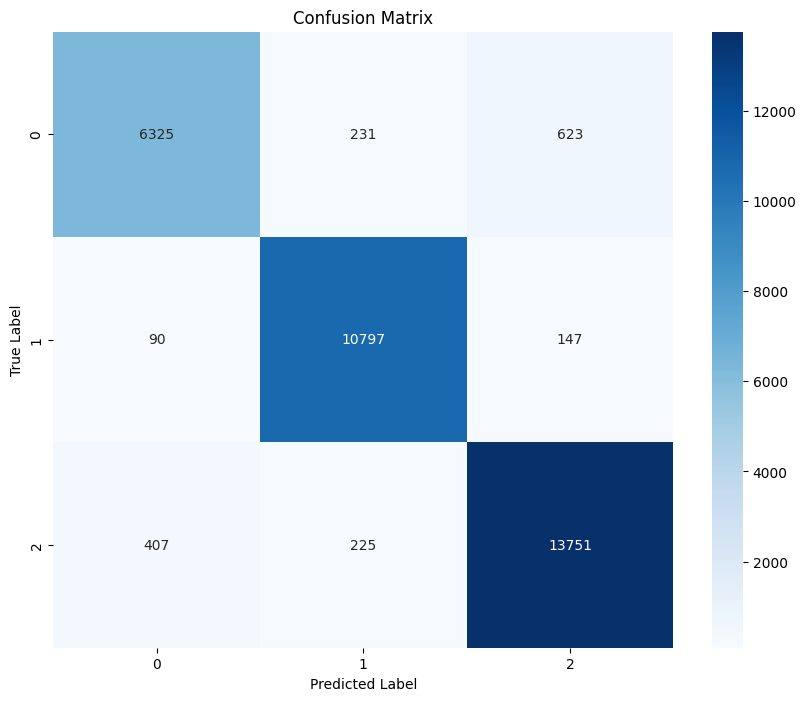

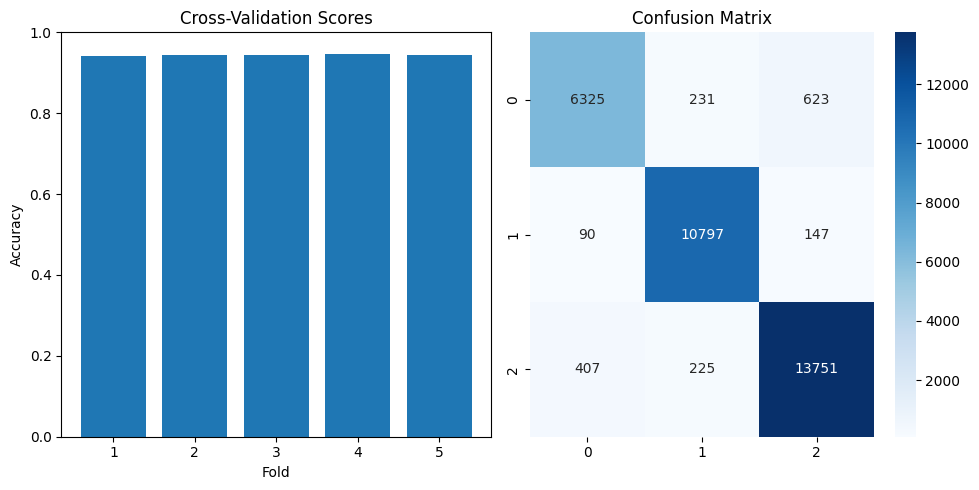

Enter text for sentiment analysis (or 'quit' to exit): happynot
Sentiment: 0.0
Enter text for sentiment analysis (or 'quit' to exit): not happy
Sentiment: -1.0
Enter text for sentiment analysis (or 'quit' to exit): harass
Sentiment: -1.0
Enter text for sentiment analysis (or 'quit' to exit): god
Sentiment: 0.0
Enter text for sentiment analysis (or 'quit' to exit): good'
Sentiment: 1.0
Enter text for sentiment analysis (or 'quit' to exit): molested
Sentiment: -1.0
Enter text for sentiment analysis (or 'quit' to exit): etc
Sentiment: 0.0
Enter text for sentiment analysis (or 'quit' to exit): asdfghjk
Sentiment: 0.0
Enter text for sentiment analysis (or 'quit' to exit): ransome
Sentiment: 0.0
Enter text for sentiment analysis (or 'quit' to exit): quit
Sentiment Analysis Model is ready!


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
#from sklearn.linear_model import LogisticRegression # Import LogisticRegression
import seaborn as sns
import joblib
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download("vader_lexicon")  # Download VADER lexicon if not already downloaded


class SentimentAnalysisModel:
    def __init__(self, model_filename="sentiment_model.joblib"):
        """
        Initialize the Sentiment Analysis Model with detailed accuracy tracking
        """
        self.model_filename = model_filename
        #self.pipeline = Pipeline([("tfidf", TfidfVectorizer()), ("clf", LinearSVC())])
        self.pipeline = Pipeline([("tfidf", TfidfVectorizer()), ("clf", LinearSVC(dual=False))]) # Initialize with dual=False if the number of samples is more than the number of features


        # Accuracy tracking attributes
        self.training_accuracy = None
        self.testing_accuracy = None
        self.cross_validation_scores = None
        self.detailed_metrics = {}

        try:
            self.load_model()
            print("Model loaded successfully!")
        except FileNotFoundError:
            print("Model file not found. Training a new model...")

    def train_model(self, X_train, y_train):
        """Trains the sentiment analysis model."""
        X_train = X_train.fillna("")

        # Perform cross-validation to get training accuracy
        self.cross_validation_scores = cross_val_score(
            self.pipeline, X_train, y_train, cv=5
        )

        # Train the model
        self.pipeline.fit(X_train, y_train)

        # Calculate training accuracy using cross-validation
        self.training_accuracy = {
            "mean_accuracy": self.cross_validation_scores.mean(),
            "std_accuracy": self.cross_validation_scores.std(),
            "individual_fold_scores": self.cross_validation_scores.tolist(),
        }

        self.save_model()

    def evaluate_model(self, X_test, y_test):
        """Evaluates the model and returns metrics."""
        X_test = X_test.fillna("")
        y_pred = self.pipeline.predict(X_test)

        # Calculate testing accuracy
        self.testing_accuracy = {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, average="weighted"),
            "recall": recall_score(y_test, y_pred, average="weighted"),
            "f1_score": f1_score(y_test, y_pred, average="weighted"),
        }

        # Detailed metrics
        self.detailed_metrics = {
            "classification_report": classification_report(y_test, y_pred),
            "confusion_matrix": confusion_matrix(y_test, y_pred),
        }

        return {
            "classification_report": self.detailed_metrics["classification_report"],
            "confusion_matrix": self.detailed_metrics["confusion_matrix"],
            "accuracy_score": self.testing_accuracy["accuracy"],
        }

    def print_accuracy_report(self):
        """
        Print comprehensive accuracy report
        """
        print("\n--- Accuracy Report ---")

        # Training Accuracy
        print("\nTraining Accuracy (Cross-Validation):")
        print(f"Mean Accuracy: {self.training_accuracy['mean_accuracy']:.4f}")
        print(f"Standard Deviation: {self.training_accuracy['std_accuracy']:.4f}")
        print(
            "Individual Fold Scores:",
            [
                f"{score:.4f}"
                for score in self.training_accuracy["individual_fold_scores"]
            ],
        )

        # Testing Accuracy
        if self.testing_accuracy:
            print("\nTesting Accuracy:")
            for metric, value in self.testing_accuracy.items():
                print(f"{metric.capitalize()}: {value:.4f}")

    def visualize_confusion_matrix(self, confusion_matrix):
        """Visualizes the confusion matrix."""
        plt.figure(figsize=(10, 8))
        sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()

    def visualize_accuracy(self):
        """
        Visualize cross-validation and testing accuracy
        """
        plt.figure(figsize=(10, 5))

        # Cross-validation scores
        plt.subplot(1, 2, 1)
        plt.bar(range(1, 6), self.training_accuracy["individual_fold_scores"])
        plt.title("Cross-Validation Scores")
        plt.xlabel("Fold")
        plt.ylabel("Accuracy")
        plt.ylim(0, 1)

        # Confusion Matrix
        if self.detailed_metrics.get("confusion_matrix") is not None:
            plt.subplot(1, 2, 2)
            sns.heatmap(
                self.detailed_metrics["confusion_matrix"],
                annot=True,
                fmt="d",
                cmap="Blues",
            )
            plt.title("Confusion Matrix")

        plt.tight_layout()
        plt.show()

    def save_model(self):
        """Saves the trained model to a file."""
        joblib.dump(self.pipeline, self.model_filename)

    def load_model(self):
        """Loads the trained model from a file."""
        self.pipeline = joblib.load(self.model_filename)

    def predict_sentiment(self, text):
        """Predicts the sentiment of the given text."""
        # 1. Use VADER for initial sentiment analysis
        analyzer = SentimentIntensityAnalyzer()
        vader_scores = analyzer.polarity_scores(text)

        # 2. If VADER detects strong negative sentiment, override model prediction
        if vader_scores["neg"] > 0.5:  # Adjust threshold as needed
            return -1.0  # Return negative sentiment (-1.0)

        # 3. Otherwise, use the model's prediction
        text = pd.Series([text]).fillna("")
        prediction = self.pipeline.predict(text)[0]
        return prediction


def prepare_dataset(df, text_column, label_column):
    """Prepares the dataset for training."""
    X_train, X_test, y_train, y_test = train_test_split(
        df[text_column], df[label_column], test_size=0.2, random_state=42
    )
    train_not_na = y_train.notna()
    X_train = X_train[train_not_na]
    y_train = y_train[train_not_na]
    test_not_na = y_test.notna()
    X_test = X_test[test_not_na]
    y_test = y_test[test_not_na]
    return X_train, X_test, y_train, y_test


def main():
    """Main function to load data, train, and evaluate the model."""
    # Use the 'on_bad_lines='skip'' argument to skip bad lines
    df = pd.read_csv("/content/Twitter_Data.csv", on_bad_lines='skip')
    text_column = "text" if "text" in df.columns else "clean_text"
    label_column = "sentiment" if "sentiment" in df.columns else "category"

    sentiment_model = SentimentAnalysisModel()

    # Train only if the model wasn't loaded from a file
    # Check if the model has been trained by checking the 'coef_' attribute of the classifier
    #if sentiment_model.pipeline.named_steps["clf"].coef_.size == 0:
    if not hasattr(sentiment_model.pipeline.named_steps["clf"], "coef_"): # Check if the 'coef_' attribute exists instead of checking its size

        X_train, X_test, y_train, y_test = prepare_dataset(
            df, text_column, label_column
        )
        sentiment_model.train_model(X_train, y_train)
        metrics = sentiment_model.evaluate_model(X_test, y_test)

        # Print detailed accuracy report
        sentiment_model.print_accuracy_report()

        # Print classification report
        print("\nClassification Report:")
        print(metrics["classification_report"])

        # Visualize confusion matrix
        sentiment_model.visualize_confusion_matrix(metrics["confusion_matrix"])

        # Visualize accuracy
        sentiment_model.visualize_accuracy()

    # Get user input and predict sentiment
    while True:
        user_input = input("Enter text for sentiment analysis (or 'quit' to exit): ")
        if user_input.lower() == "quit":
            break
        prediction = sentiment_model.predict_sentiment(user_input)
        print("Sentiment:", prediction)


if __name__ == "__main__":
    main()

print("Sentiment Analysis Model is ready!")
